# 02 — Exploratory Analysis (SQL-first)
**Formula 1 Race Strategy Analytics** — End-to-end data analytics project

**Goal:** Run core exploratory analyses directly from SQL (SQLite), then produce simple visuals to support a future Power BI dashboard.

In [23]:
import os
print(os.path.exists("/content/sample_f1_data/f1.db"))


True


In [24]:


import os, sqlite3, pandas as pd, numpy as np
import matplotlib.pyplot as plt

CANDIDATE_PATHS = ["../data/f1.db", "/content/sample_f1_data/f1.db", "data/f1.db"]
DB_PATH = next((p for p in CANDIDATE_PATHS if os.path.exists(p)), None)
if DB_PATH is None:
    raise FileNotFoundError("Could not find f1.db. Upload it or set DB_PATH manually.")
print("Using database:", DB_PATH)

def q(sql: str) -> pd.DataFrame:
    with sqlite3.connect(DB_PATH) as conn:
        return pd.read_sql(sql, conn)


Using database: /content/sample_f1_data/f1.db


In [25]:
q("SELECT name FROM sqlite_master WHERE type='table' ORDER BY 1;")

,name
0,circuits
1,constructors
2,drivers
3,lap_times
4,pit_stops
5,qualifying
6,races
7,results


In [26]:

wins_sql = '''
SELECT d.givenName || ' ' || d.familyName AS driver,
       COUNT(*) AS wins
FROM results r
JOIN drivers d ON d.driverId = r.driverId
WHERE r.position GLOB '[0-9]*' AND CAST(r.position AS INTEGER) = 1
GROUP BY r.driverId
ORDER BY wins DESC, driver ASC;
'''
wins = q(wins_sql); wins


,driver,wins
0,Charles Leclerc,1
1,Max Verstappen,1


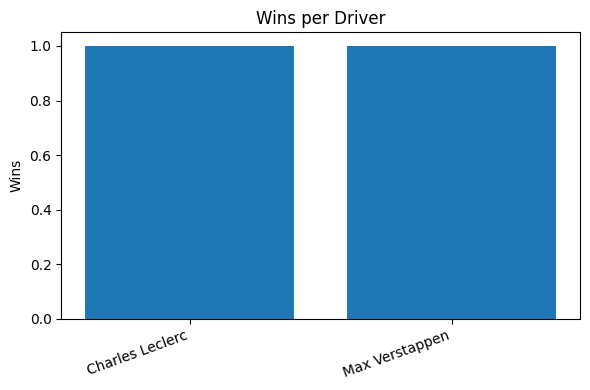

In [27]:

plt.figure(figsize=(6,4))
plt.bar(wins['driver'], wins['wins'])
plt.title("Wins per Driver")
plt.ylabel("Wins")
plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()


In [28]:

avg_points_sql = '''
SELECT d.givenName || ' ' || d.familyName AS driver,
       ROUND(AVG(CAST(r.points AS REAL)), 2) AS avg_points
FROM results r
JOIN drivers d ON d.driverId = r.driverId
WHERE r.points GLOB '[0-9]*'
GROUP BY r.driverId
ORDER BY avg_points DESC, driver ASC;
'''
avg_points = q(avg_points_sql); avg_points


,driver,avg_points
0,Charles Leclerc,21.5
1,Max Verstappen,21.5
2,Lando Norris,15.0


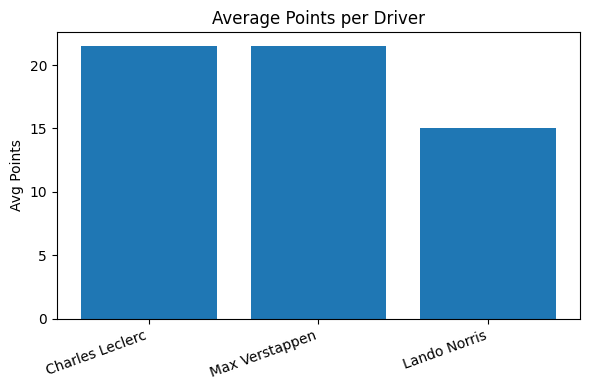

In [29]:

plt.figure(figsize=(6,4))
plt.bar(avg_points['driver'], avg_points['avg_points'])
plt.title("Average Points per Driver")
plt.ylabel("Avg Points")
plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()


In [30]:

positions_gained_sql = '''
WITH clean AS (
  SELECT CAST(grid AS INTEGER) AS grid,
         CAST(position AS INTEGER) AS finish,
         driverId
  FROM results
  WHERE grid GLOB '[0-9]*' AND position GLOB '[0-9]*'
)
SELECT d.givenName || ' ' || d.familyName AS driver,
       ROUND(AVG(grid - finish), 2) AS avg_positions_gained
FROM clean c
JOIN drivers d ON d.driverId = c.driverId
GROUP BY c.driverId
ORDER BY avg_positions_gained DESC, driver ASC;
'''
pos_gain = q(positions_gained_sql); pos_gain


,driver,avg_positions_gained
0,Lando Norris,1.5
1,Charles Leclerc,0.5
2,Max Verstappen,0.0


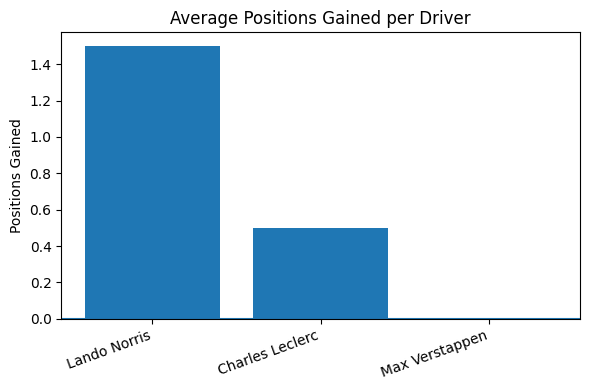

In [31]:

plt.figure(figsize=(6,4))
plt.bar(pos_gain['driver'], pos_gain['avg_positions_gained'])
plt.title("Average Positions Gained per Driver")
plt.ylabel("Positions Gained")
plt.axhline(0)
plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()


In [32]:

pit_team_sql = '''
WITH pit AS (
  SELECT season, round, driverId, CAST(duration AS REAL) AS dur
  FROM pit_stops
  WHERE duration != ''
)
SELECT c.name AS constructor,
       ROUND(AVG(p.dur), 2) AS avg_pit_s
FROM pit p
JOIN results r ON r.season = p.season AND r.round = p.round AND r.driverId = p.driverId
JOIN constructors c ON c.constructorId = r.constructorId
GROUP BY c.constructorId
ORDER BY avg_pit_s ASC;
'''
pit_team = q(pit_team_sql); pit_team


,constructor,avg_pit_s
0,Red Bull,2.4
1,Ferrari,2.6
2,McLaren,2.7


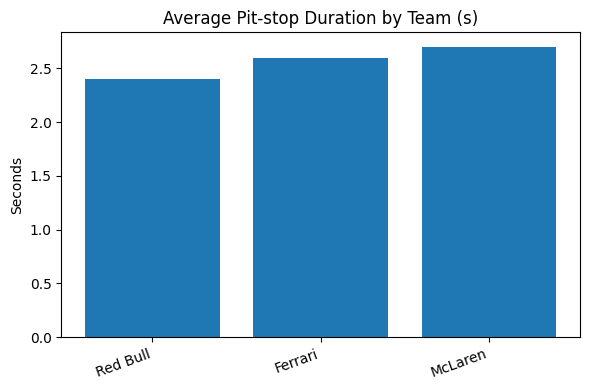

In [33]:

plt.figure(figsize=(6,4))
plt.bar(pit_team['constructor'], pit_team['avg_pit_s'])
plt.title("Average Pit-stop Duration by Team (s)")
plt.ylabel("Seconds")
plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()


In [34]:

grid_finish_sql = '''
SELECT
  CAST(r.grid     AS INTEGER)  AS grid,
  CAST(r.position AS INTEGER)  AS finish,
  r.status
FROM results r
WHERE r.grid GLOB '[0-9]*'
  AND r.position GLOB '[0-9]*'
  AND CAST(r.grid AS INTEGER) > 0
  AND CAST(r.position AS INTEGER) > 0;
'''
grid_finish = q(grid_finish_sql); grid_finish.head()


,grid,finish,status
0,1,1,Finished
1,3,2,Finished
2,5,3,Finished
3,1,1,Finished
4,2,2,Finished


In [35]:

pearson_r  = grid_finish[['grid','finish']].corr().loc['grid','finish']
spearman_r = grid_finish[['grid','finish']].corr(method='spearman').loc['grid','finish']
print("Pearson r:", round(float(pearson_r), 3))
print("Spearman r:", round(float(spearman_r), 3))


Pearson r: 0.959
Spearman r: 0.97


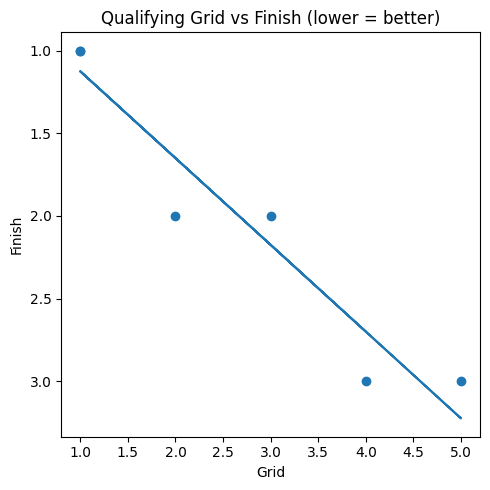

In [36]:

x = grid_finish['grid'].astype(int).values
y = grid_finish['finish'].astype(int).values
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(5,5))
plt.scatter(x, y)
plt.plot(x, m*x + b)
plt.title("Qualifying Grid vs Finish (lower = better)")
plt.xlabel("Grid")
plt.ylabel("Finish")
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()


In [37]:

circuit_perf_sql = '''
SELECT
  ci.circuitName AS circuit,
  ROUND(AVG(CAST(r.position AS REAL)), 2) AS avg_finish
FROM results r
JOIN races ra ON ra.season = r.season AND ra.round = r.round
JOIN circuits ci ON ci.circuitId = ra.circuitId
WHERE r.position GLOB '[0-9]*'
GROUP BY ci.circuitId
ORDER BY avg_finish ASC;
'''
circuit_perf = q(circuit_perf_sql); circuit_perf


,circuit,avg_finish
0,Bahrain International Circuit,2.0
1,Circuit de Monaco,2.0


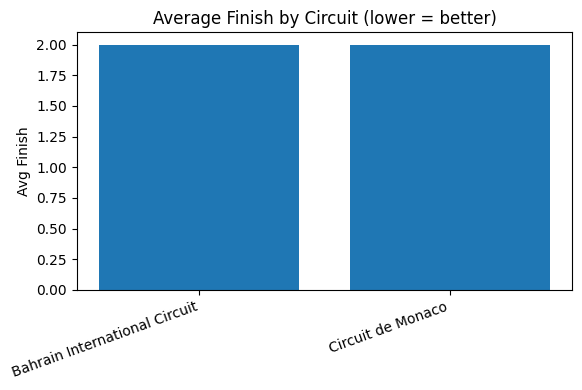

In [38]:

plt.figure(figsize=(6,4))
plt.bar(circuit_perf['circuit'], circuit_perf['avg_finish'])
plt.title("Average Finish by Circuit (lower = better)")
plt.ylabel("Avg Finish")
plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()
